# Example of MCMC run

In [1]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5
using BenchmarkTools

In [2]:
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements
using BenchmarkTools
using DSP

In [3]:
# using Revise
using BAT 

# Load Data

In [4]:
function trunc_norm(m, sgm; alpha=2)
    return truncated(Normal(m, sgm), m - alpha*sgm, m + alpha*sgm)
end

trunc_norm (generic function with 1 method)

## 1.1 Low `p` Population: 

In [36]:
conv_mat = load("../data/experiment/dataset_2/m1/conv-matrix-upd-2.jld2")

conv_matrices = (
    cam_1 = conv_mat["cam_1"],
    cam_2 = conv_mat["cam_2"],
    cam_3 = conv_mat["cam_3"],
    cam_4 = conv_mat["cam_4"], 
)

images = load("../data/experiment/dataset_2/m1/images-satur.jld2");
event_number = 9

# Small Charge: Ev_1_3 = 343, Ev_1_1 = 137, Ev_1_2 = 9

event = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
);

## 1.2 High `p` Population: 

In [5]:
# conv_mat = load("../data/experiment/dataset_2/m2/conv-matrix-upd-2.jld2") 

# conv_matrices = (
#     cam_1 = conv_mat["cam_1"],
#     cam_2 = conv_mat["cam_2"],
#     cam_3 = conv_mat["cam_3"],
#     cam_4 = conv_mat["cam_4"], 
# ) 

# images = load("../data/experiment/dataset_2/m2/images-satur.jld2"); # removed saturated pixels
# # images = load("../data/experiment/dataset_2/m2/images.jld2"); # included saturated pixels
# event_number = 1

# # Large Charge: Ev_2_2 = 2, Ev_2_1 = 311, Ev_2_3 = 440

# event = (
#     cam_1 = images["cam_1"][event_number,:,:],
#     cam_2 = images["cam_2"][event_number,:,:],
#     cam_3 = images["cam_3"][event_number,:,:],
#     cam_4 = images["cam_4"][event_number,:,:],
#     population = images["charge"][event_number,:][1],
# );


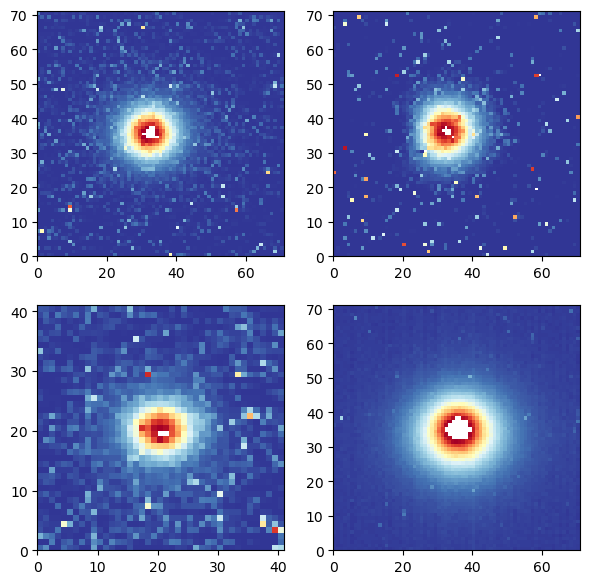

PyObject <matplotlib.collections.QuadMesh object at 0x7fefa5d383a0>

In [37]:
fig, ax = plt.subplots(2,2, figsize=(7,7))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

ax[1,1].pcolormesh(event.cam_1, cmap="RdYlBu_r")
ax[1,2].pcolormesh(event.cam_2, cmap="RdYlBu_r")
ax[2,1].pcolormesh(event.cam_3, cmap="RdYlBu_r")
ax[2,2].pcolormesh(event.cam_4, cmap="RdYlBu_r")

# Load Model

## Model 35: 

In [ ]:
# include("../src/model-35/likelihood.jl")
# include("../src/model-35/utill_model.jl")
# include("../src/utill.jl")

In [ ]:
# β1= 0.015
# β2 = 0.0077
# β3 = 0.0058

# # # flat prior for the pixel size
# # prior = NamedTupleDist(
# #         tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
# #         ang_spr = [truncated(Normal(4.0, 2.0), 2.0, 6.0), truncated(Normal(4.0, 2.0), 2.0, 6.0)],
# #         waist = [Normal(2.9, 0.03)],
# #         algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
# #         algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
# #         cam4_ped = 4.0 .. 40.0,
# #         cam4_light_fluct = 1.0 .. 3.0,
# #         cam4_light_amp = 1.6 .. 9.9, 
# #         resx = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
# #         resy = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
# #         cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
# #         cam4_resy = truncated(Normal(3, 1.5), 0, Inf),
# #         psx = [truncated(Normal(27.1, 27.1*β1), 0., Inf), truncated(Normal(21.6, 21.6*β1), 0., Inf), truncated(Normal(114.0, 114.0*β2), 0., Inf)], # pixels are in microns
# #         psy = [truncated(Normal(30.5, 30.5*β1), 0., Inf), truncated(Normal(23.4, 23.4*β1), 0., Inf), truncated(Normal(125.0, 125.0*β2), 0., Inf)],
# #         cam4_psx = truncated(Normal(121.8, 3*121.8*β3), 0., Inf), # original Pixel size (smaller) 91.0; Updated Pixel size (larger) 121.2
# #         cam4_psy = truncated(Normal(120.0, 3*120.0*β3), 0., Inf), # original Pixel size (smaller) 89.4; Updated Pixel size (larger) 120.6
# #         light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
# #         s_cam = [0.0, 1.478, 15.026, 23.1150],
# #     ); 

## Model 38: 

In [ ]:
# include("../src/model-38/likelihood.jl")
# include("../src/model-38/utill_model.jl")
# include("../src/utill.jl")

In [ ]:
# β1= 0.015
# β2 = 0.0077
# β3 = 0.0058 

# prior = NamedTupleDist(
#     tr_size = [truncated(Normal(0.2, 0.04), 0.08, 0.25), truncated(Normal(0.2, 0.04), 0.08, 0.25)],
#     ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 7.0), truncated(Normal(4.0, 2.0), 4.0, 7.0)],
#     ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 3.5), truncated(Normal(4.0, 2.0), 1.0, 3.5)],
#     mixt_pow =  0.50 .. 1.0 ,
#     waist = [truncated(Normal(2.9, 0.03), 2.65, 3.3)],
#     algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     cam4_ped = 4.0 .. 40.0,
#     cam4_light_fluct = 1.0 .. 3.0,
#     cam4_light_amp = 1.6 .. 9.9, 
#     resx = [trunc_norm(1, 0.5), trunc_norm(2, 1), trunc_norm(1, 0.5)], # 23, 24, 25, 
#     resy = [trunc_norm(1, 0.5), trunc_norm(2, 1), trunc_norm(1, 0.5)], # 26,27, 28, 
#     cam4_resx = trunc_norm(3, 1.5), # 29, 
#     cam4_resy = trunc_norm(3, 1.5), # 30
#     psx = [trunc_norm(27.1, 27.1*β1), trunc_norm(21.6, 21.6*β1), trunc_norm(114.0, 114.0*β2)], # 31, 32, 33
#     psy = [trunc_norm(30.5, 30.5*β1), trunc_norm(23.4, 23.4*β1), trunc_norm(125.0, 125.0*β2)], # 34, 35, 36
#     cam4_psx = trunc_norm(121.8, 121.8*β3), # 37
#     cam4_psy = trunc_norm(120.0, 120.0*β3), # 38
#     light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
#     s_cam = [0.0, 1.478, 15.026, 23.1150],
# ) ;

# prior = NamedTupleDist(
#     tr_size = [truncated(Normal(0.2, 0.04), 0.06, 0.20), truncated(Normal(0.2, 0.04), 0.06, 0.20)],
#     ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 7.0), truncated(Normal(4.0, 2.0), 4.0, 7.0)],
#     ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 3.5), truncated(Normal(4.0, 2.0), 1.0, 3.5)],
#     mixt_pow =  0.50 .. 1.0 ,
#     waist = [truncated(Normal(2.9, 0.03), 2.65, 3.3)],
#     algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     cam4_ped = 4.0 .. 40.0,
#     cam4_light_fluct = 2.0,
#     cam4_light_amp = 1.6 .. 9.9, 
#     resx = [1, 1, 1], # 23, 24, 25, 
#     resy = [1, 1, 1], # 26,27, 28, 
#     cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
#     cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
#     psx = [27.1, 21.6, 114.0], # 31, 32, 33
#     psy = [30.5, 23.4, 125.0], # 34, 35, 36
#     cam4_psx = 121.8, # 37
#     cam4_psy = 120.0, # 38
#     light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
#     s_cam = [0.0, 1.478, 15.026, 23.1150],
# ) ;

## Model 41: 

In [38]:
include("../src/model-41/likelihood.jl")
include("../src/model-41/utill_model.jl")
include("../src/utill.jl")

plot_projections (generic function with 1 method)

In [ ]:
# β1 = 0.015
# β2 = 0.0077
# β3 = 0.0058 

# prior = NamedTupleDist(
#     tr_size = [truncated(Normal(0.2, 0.04), 0.035, 0.25), truncated(Normal(0.2, 0.04), 0.035, 0.25)],
#     tr_size_2 = [truncated(Normal(0.2, 0.04), 0.035, 0.25), truncated(Normal(0.2, 0.04), 0.035, 0.25)],
#     ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 7.0), truncated(Normal(4.0, 2.0), 4.0, 7.0)],
#     ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 3.5), truncated(Normal(4.0, 2.0), 1.0, 3.5)],
#     mixt_pow =  0.50 .. 1.0 ,
#     waist = [truncated(Normal(2.9, 0.03), 2.65, 3.3)],
#     waist_2 = [truncated(Normal(2.9, 0.03), 2.65, 3.3)], # 11
#     algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     cam4_ped = 4.0 .. 40.0,
#     cam4_light_fluct = 1.0 .. 3.0,
#     cam4_light_amp = 1.6 .. 9.9, 
#     resx = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], # 23, 24, 25, 
#     resy = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(2, 1), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], # 26,27, 28, 
#     cam4_resx = truncated(Normal(3, 1.5), 0, Inf), # 29, 
#     cam4_resy = truncated(Normal(3, 1.5), 0, Inf), # 30
#     psx = [truncated(Normal(27.1, 27.1*β1), 0., Inf), truncated(Normal(21.6, 21.6*β1), 0., Inf), truncated(Normal(114.0, 114.0*β2), 0., Inf)], # 31, 32, 33
#     psy = [truncated(Normal(30.5, 30.5*β1), 0., Inf), truncated(Normal(23.4, 23.4*β1), 0., Inf), truncated(Normal(125.0, 125.0*β2), 0., Inf)], # 34, 35, 36
#     cam4_psx = truncated(Normal(121.8, 121.8*β3), 0., Inf), # 37
#     cam4_psy = truncated(Normal(120.0, 120.0*β3), 0., Inf), # 38
#     light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
#     s_cam = [0.0, 1.478, 15.026, 23.1150],
# ) ;

In [41]:
β1= 0.015
β2 = 0.0077
β3 = 0.0058 

# prior = NamedTupleDist(
#     tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.25), truncated(Normal(0.2, 0.04), 0.03, 0.25)],
#     tr_size_2 = [truncated(Normal(0.2, 0.04), 0.03, 0.25), truncated(Normal(0.2, 0.04), 0.03, 0.25)],
#     ang_spr = [truncated(Normal(4.0, 2.0), 4.5, 7.5), truncated(Normal(4.0, 2.0), 4.5, 7.5)],
#     ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 4.0), truncated(Normal(4.0, 2.0), 1.0, 4.0)],
#     mixt_pow =  0.51 .. 1.0 ,
#     waist = [truncated(Normal(2.9, 0.03), 2.65, 3.5)],
#     waist_2 = [truncated(Normal(2.9, 0.03), 2.65, 3.5)], # 11
#     algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     cam4_ped = 4.0 .. 40.0,
#     cam4_light_fluct = 1.0 .. 3.0,
#     cam4_light_amp = 1.6 .. 9.9, 
#     resx = [trunc_norm(1, 0.5), trunc_norm(1, 0.5), trunc_norm(1, 0.5)], # 23, 24, 25, 
#     resy = [trunc_norm(1, 0.5), trunc_norm(1, 0.5), trunc_norm(1, 0.5)], # 26,27, 28, 
#     cam4_resx = trunc_norm(3, 1.5), # 29, 
#     cam4_resy = trunc_norm(3, 1.5), # 30
#     psx = [trunc_norm(27.1, 27.1*β1), trunc_norm(21.6, 21.6*β1), trunc_norm(114.0, 114.0*β2)], # 31, 32, 33
#     psy = [trunc_norm(30.5, 30.5*β1), trunc_norm(23.4, 23.4*β1), trunc_norm(125.0, 125.0*β2)], # 34, 35, 36
#     cam4_psx = trunc_norm(121.8, 121.8*β3), # 37
#     cam4_psy = trunc_norm(120.0, 120.0*β3), # 38
#     light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
#     s_cam = [0.0, 1.478, 15.026, 23.1150],
# ) ;

# prior = NamedTupleDist(
#     tr_size = [truncated(Normal(0.2, 0.04), 0.03, 0.16), truncated(Normal(0.2, 0.04), 0.03, 0.16)],
#     tr_size_2 = [truncated(Normal(0.2, 0.04), 0.03, 0.16), truncated(Normal(0.2, 0.04), 0.03, 0.16)],
#     ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 7.0), truncated(Normal(4.0, 2.0), 4.0, 7.0)],
#     ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 4.0), truncated(Normal(4.0, 2.0), 1.0, 4.0)],
#     mixt_pow =  0.50 .. 1.0 ,
#     waist = [truncated(Normal(2.9, 0.03), 2.65, 3.5)],
#     waist_2 = [truncated(Normal(2.9, 0.03), 2.65, 3.5)], # 11
#     algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
#     cam4_ped = 4.0 .. 40.0,
#     cam4_light_fluct = 2.0,
#     cam4_light_amp = 1.6 .. 9.9, 
#     resx = [1, 1, 1], # 23, 24, 25, 
#     resy = [1, 1, 1], # 26,27, 28, 
#     cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
#     cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
#     psx = [27.1, 21.6, 114.0], # 31, 32, 33
#     psy = [30.5, 23.4, 125.0], # 34, 35, 36
#     cam4_psx = 121.8, # 37
#     cam4_psy = 120.0, # 38
#     light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
#     s_cam = [0.0, 1.478, 15.026, 23.1150],
# ) ; # used in sampling

prior = NamedTupleDist(
        tr_size = [truncated(Normal(0.2, 0.04), 0.02, 0.16), truncated(Normal(0.2, 0.04), 0.02, 0.16)],
        tr_size_2 = [truncated(Normal(0.2, 0.04), 0.02, 0.16), truncated(Normal(0.2, 0.04), 0.02, 0.16)],
        ang_spr = [truncated(Normal(4.0, 2.0), 4.0, 8.5), truncated(Normal(4.0, 2.0), 4.0, 8.5)],
        ang_spr_2 = [truncated(Normal(4.0, 2.0), 1.0, 4.0), truncated(Normal(4.0, 2.0), 1.0, 4.0)],
        mixt_pow =  0.50 .. 1.0 ,
        waist = [truncated(Normal(2.9, 0.03), 2.65, 3.5)],
        waist_2 = [truncated(Normal(2.9, 0.03), 2.65, 3.5)], # 11
        algmx = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        algmy = [23.0 .. 48, 23.0 .. 48.0, 10.0 .. 30.0, 23.0 .. 48.0],
        cam4_ped = 4.0 .. 40.0,
        cam4_light_fluct =  1.0 .. 3.0,
        cam4_light_amp = 1.6 .. 9.9, 
        resx = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        resy = [truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf), truncated(Normal(1, 0.5), 0, Inf)], 
        cam4_resx = truncated(Normal(3, 1.5), 0, Inf),
        cam4_resy = truncated(Normal(3, 1.5), 0, Inf), 
        psx = [27.1, 21.6, 114.0], # 31, 32, 33
        psy = [30.5, 23.4, 125.0], # 34, 35, 36
        cam4_psx = 121.8, # 37
        cam4_psy = 120.0, # 38
        light_amp  = [1.0 .. 13.0 , 1.0 .. 17.0, 1.0 .. 5.0], # 1.0 .. 5.0
        s_cam = [0.0, 1.478, 15.026, 23.1150],
);

# MCMC settings: 

In [42]:
"""
    Log-Likelihood of the beamline (4 cameras included)
"""
function log_lik_ndiff(;  
    e = event,
    cv_mat = conv_matrices,
    func = conv_tabl_discrete,
    cv_1 = cv_mat.cam_1,
    cv_2 = cv_mat.cam_2,
    cv_3 = cv_mat.cam_3,
    n_threads = Threads.nthreads(),
    )
    
    return params -> begin 
        ll = 0.0
        ll += likelihood_cam13(params, e.cam_1, e.population, cv_1, func, 1, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_2, e.population, cv_2, func, 2, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_3, e.population, cv_3, func, 3, n_threads=n_threads)
        ll += likelihood_cam4(params, e.cam_4, e.population, 4, n_threads=n_threads)
        return LogDVal(ll)
    end
        
end

function log_lik_diff(;  
    e = event,
    cv_mat = conv_matrices,
    func = conv_tabl_cont,
    cv_1 = exp.(cv_mat.cam_1),
    cv_2 = exp.(cv_mat.cam_2),
    cv_3 = exp.(cv_mat.cam_3),
    n_threads = Threads.nthreads(),
    )
    
    return params -> begin 
        ll = 0.0
        ll += likelihood_cam13(params, e.cam_1, e.population, cv_1, func, 1, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_2, e.population, cv_2, func, 2, n_threads=n_threads)
        ll += likelihood_cam13(params, e.cam_3, e.population, cv_3, func, 3, n_threads=n_threads)
        ll += likelihood_cam4(params, e.cam_4, e.population, 4, n_threads=n_threads)
        
        return LogDVal(ll)
    end
    
end

# log_likelihood = log_lik_diff()

log_likelihood = log_lik_ndiff()

#113 (generic function with 1 method)

In [43]:
posterior = PosteriorDensity(log_likelihood, prior)

tuning = AdaptiveMHTuning(
    λ = 0.5,
    α = ClosedInterval(0.15,0.25),
    β = 1.5,
    c = ClosedInterval(1e-4,1e2),
    r = 0.5,
)

convergence = BrooksGelmanConvergence(
    threshold = 1.1,
    corrected = false
)

init = MCMCChainPoolInit(
    init_tries_per_chain = ClosedInterval(50,150),
    max_nsamples_init = 500,
    max_nsteps_init = 500,
    max_time_init = Inf
)

burnin = MCMCMultiCycleBurnin(
    max_nsamples_per_cycle = 10000,
    max_nsteps_per_cycle = 10000,
    max_time_per_cycle = Inf,
    max_ncycles = 130
)

nsamples = 4*10^5
nchains = 4

sampler = MetropolisHastings(tuning=tuning,)

algorithm = MCMCSampling(sampler=sampler, 
    nchains=nchains, 
    init=init, 
    burnin=burnin, 
    convergence=convergence
);

In [44]:
# log_likelihood(param_truth)
# @benchmark log_likelihood(param_truth)

In [ ]:
@time samples_tot = bat_sample(
    posterior, nchains*nsamples, algorithm,
    max_neval = nchains*nsamples,
    max_time = Inf,
);

┌ Info: Initializing new RNG of type Random123.Philox4x{UInt64,10}
└ @ BAT /user/.julia/packages/BAT/kyKKZ/src/algotypes/bat_default.jl:44
┌ Info: Trying to generate 4 viable MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/kyKKZ/src/samplers/mcmc/chain_pool_init.jl:63
┌ Info: Selected 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/kyKKZ/src/samplers/mcmc/chain_pool_init.jl:185
┌ Info: Begin tuning of 4 MCMC chain(s).
└ @ BAT /user/.julia/packages/BAT/kyKKZ/src/samplers/mcmc/multi_cycle_burnin.jl:38
┌ Info: MCMC Tuning cycle 1 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/kyKKZ/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC Tuning cycle 2 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/kyKKZ/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC Tuning cycle 3 finished, 4 chains, 0 tuned, 0 converged.
└ @ BAT /user/.julia/packages/BAT/kyKKZ/src/samplers/mcmc/multi_cycle_burnin.jl:70
┌ Info: MCMC Tuning cycle 4 fini

In [ ]:
samples = samples_tot.result;

In [ ]:
minimum(bat_eff_sample_size(unshaped.(samples)).result)

In [15]:
size(flatview(unshaped.(samples.v)))

(33, 347178)

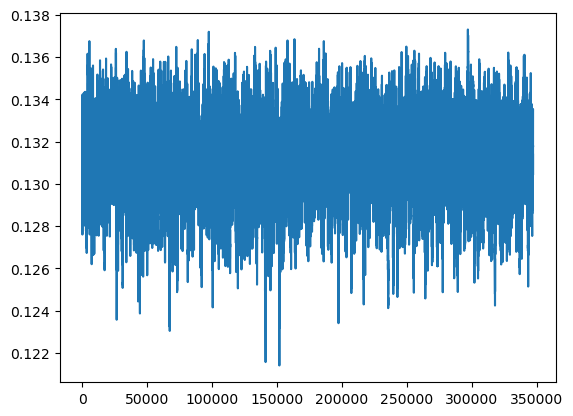

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fef4482fd00>

In [16]:
plot(flatview(unshaped.(samples.v))[3,:])

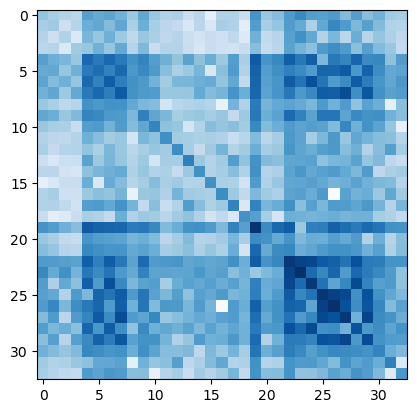

PyObject <matplotlib.image.AxesImage object at 0x7fef448185b0>

In [17]:
plt.imshow(log.(abs.(cov(flatview(unshaped.(samples.v))'))), cmap="Blues")

In [18]:
# BAT.bat_write("../data/sampling_results/Tmp-Mixture-Model-38-2/mm-38-hc-2-fixed-lf.hdf5", unshaped.(samples))

# BAT.bat_write("../data/sampling_results/To_delete_2/new_cv-nontr.hdf5", unshaped.(samples))

In [19]:
#  27.1, 21.6, 114.0, 30.5, 23.4, 125.0, 121.8, 120.0

In [20]:
mode(samples)[1]

(tr_size = [0.0913054053721668, 0.12955383348426835], tr_size_2 = [0.13142191364910216, 0.14215793130285143], ang_spr = [6.030403177370175, 5.752135031380182], ang_spr_2 = [2.4728814689249368, 2.602776175665383], mixt_pow = 0.7350876310510261, waist = [3.1758123009570367], waist_2 = [2.8380565182237296], algmx = [34.749316157365854, 35.8336245884103, 21.804427342592433, 35.31800400425221], algmy = [37.420164852582936, 37.92810065087452, 20.542431993342664, 33.863597455835134], cam4_ped = 29.743939843363847, cam4_light_fluct = 1.9056250769863072, cam4_light_amp = 8.835533355056812, resx = [1.076605814530531, 0.902121466956637, 0.35816244084245663], resy = [0.8464063556677949, 1.2950284756227615, 0.4463377721741555], cam4_resx = 4.671047462732233, cam4_resy = 4.075120002424133, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [8.568375343207908, 11.179108717275458, 2.799263909751397], s_cam = [0.0, 1.478, 15.026, 23.115])

In [21]:
bat_marginalmode(samples).result

ShapedAsNT((tr_size = [0.0927, 0.13090000000000002], tr_size_2 = [0.13155, 0.1461], ang_spr = [6.0375, 5.737500000000001], ang_spr_2 = [2.5125, 2.5975], mixt_pow = 0.72675, waist = [3.161], waist_2 = [2.851], algmx = [34.7425, 35.829, 21.808999999999997, 35.326499999999996], algmy = [37.412499999999994, 37.953500000000005, 20.564999999999998, 33.8595], cam4_ped = 29.25, cam4_light_fluct = 1.9215, cam4_light_amp = 8.8325, resx = [1.21, 0.87, 0.565], resy = [0.835, 1.05, 0.515], cam4_resx = 4.675, cam4_resy = 4.1850000000000005, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [8.579, 11.177, 2.7845], s_cam = [0.0, 1.478, 15.026, 23.115]))

In [22]:
mean(samples)[1]

(tr_size = [0.09127772591625605, 0.13029837699483654], tr_size_2 = [0.13131403698858157, 0.14575721050843637], ang_spr = [6.0613732037353465, 5.731702838001445], ang_spr_2 = [2.472496862449094, 2.563909260722149], mixt_pow = 0.7265009843826487, waist = [3.1653158162791124], waist_2 = [2.8536145494873364], algmx = [34.741484763483854, 35.828099409871776, 21.805765183980185, 35.32726395236464], algmy = [37.41605180616506, 37.959470601757445, 20.56005663450535, 33.85841074558617], cam4_ped = 29.269494717415892, cam4_light_fluct = 1.9209778860534368, cam4_light_amp = 8.83080810257435, resx = [1.2337483056371148, 0.8051663400490099, 0.5874468562216749], resy = [0.8156200944054901, 0.979325171501606, 0.6043765088829416], cam4_resx = 4.727155951988425, cam4_resy = 4.249143845236754, psx = [27.1, 21.6, 114.0], psy = [30.5, 23.4, 125.0], cam4_psx = 121.8, cam4_psy = 120.0, light_amp = [8.58316969162574, 11.177492849580137, 2.783910844878483], s_cam = [0.0, 1.478, 15.026, 23.115])

In [23]:
std(samples)[1]

(tr_size = [0.0037321044031077516, 0.0029036379350236745], tr_size_2 = [0.0018647856154144244, 0.0027966223890407895], ang_spr = [0.07068348595453122, 0.060759310923001665], ang_spr_2 = [0.1015545994716209, 0.11149755701033197], mixt_pow = 0.009741459949688886, waist = [0.034389102248569656], waist_2 = [0.030580290302859487], algmx = [0.022344003095575746, 0.024568438432922772, 0.036051080377049675, 0.02168911941755254], algmy = [0.021199081468271843, 0.02469721347557842, 0.03228976740469436, 0.020757062822460107], cam4_ped = 0.34001341214520925, cam4_light_fluct = 0.02016318294245095, cam4_light_amp = 0.025238575773898486, resx = [0.31084048648024726, 0.39304706841320475, 0.3150365945274679], resy = [0.3363402980115784, 0.41241551312321334, 0.3174851976316505], cam4_resx = 0.1389682451167487, cam4_resy = 0.1720327828669407, psx = 3-element Fill{Float64}: entries equal to 0.0, psy = 3-element Fill{Float64}: entries equal to 0.0, cam4_psx = 0.0, cam4_psy = 0.0, light_amp = [0.0315101592

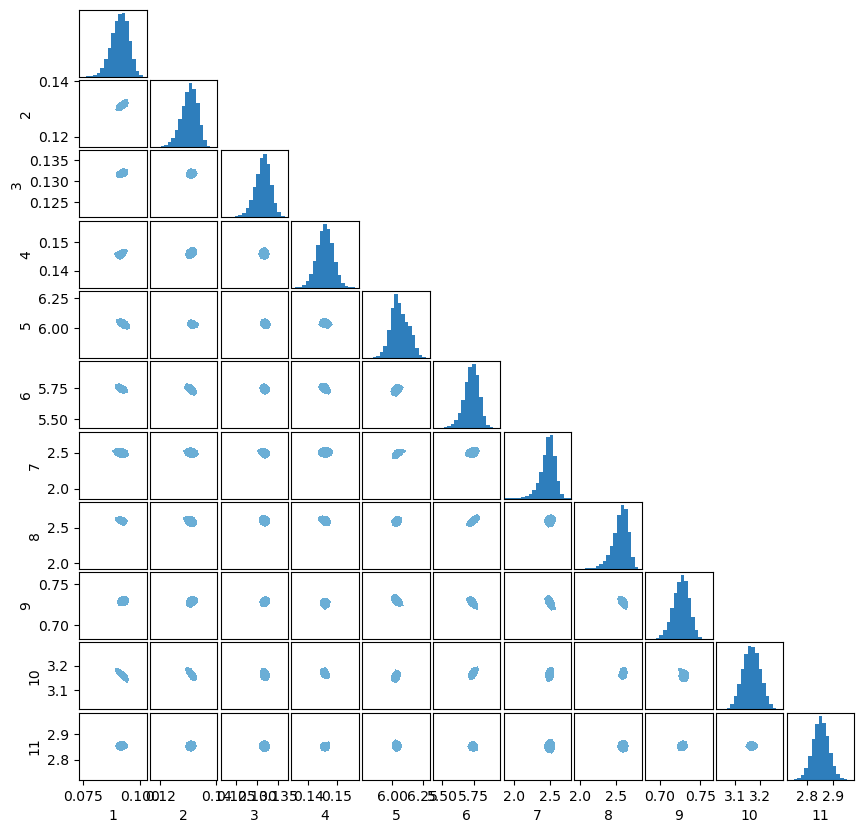

In [24]:
dims = [1,2,3,4,5,6,7,8,9,10,11]
# dims = [1,2,3,4,5,]
names = [1,2,3,4,5,6,7,8,9,10, 11]
levels = [0.01, 0.55, 0.9, 0.95,  1,]
levels = [0.001, 0.98, 1,]
figsize = (10,10)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

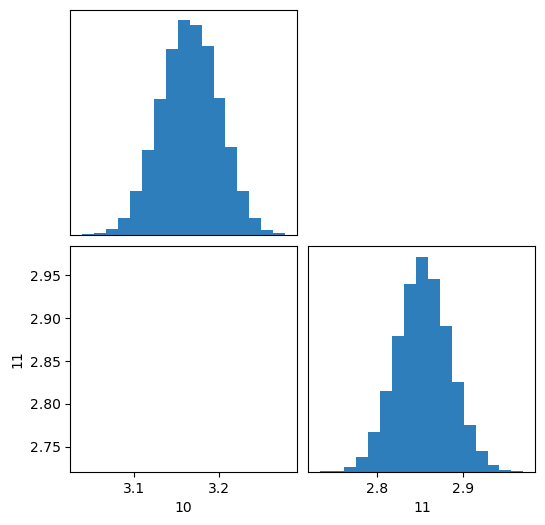

In [25]:
dims = [10,11,]
names = [10,11,]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
levels = [0.1,  1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

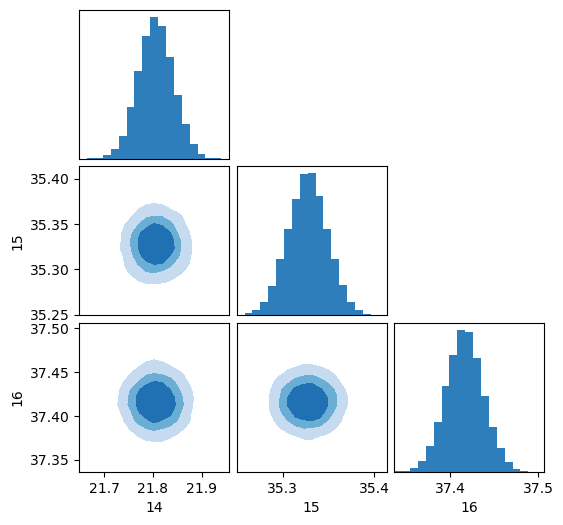

In [26]:
dims = [14,15,16,]
names = [14,15,16,]
levels = [0.1, 0.8, 0.9, 0.95,  1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

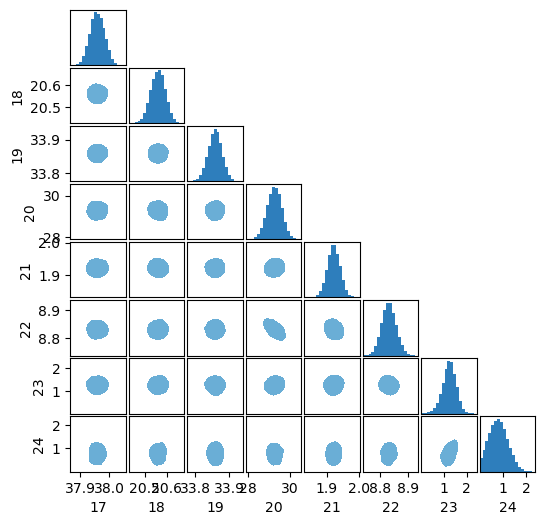

In [27]:
# res

dims = [17,18,19,20,21,22,23,24]
names = [17,18,19,20,21, 22, 23, 24]
levels = [0.1, 0.5, 0.9, 0.95,  1,]
levels = [0.1, 0.9, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

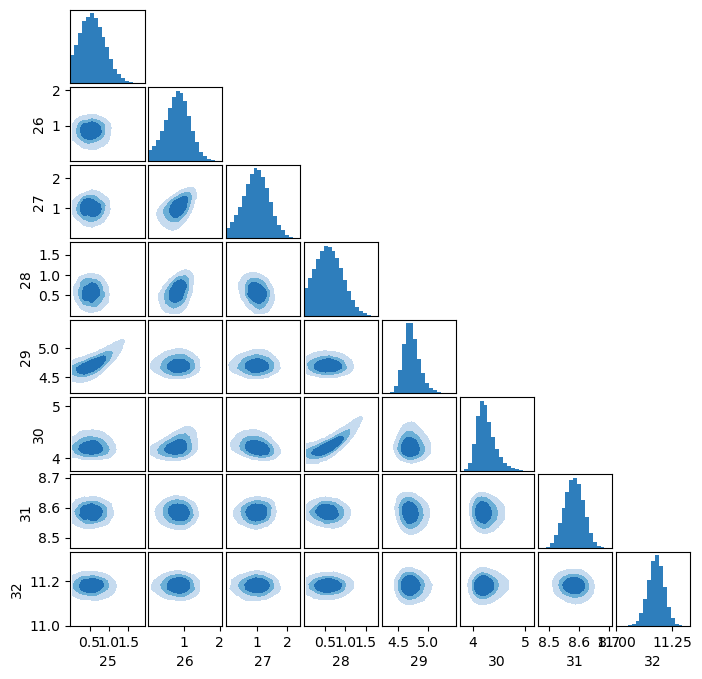

In [28]:
#pix

dims = [25,26,27,28,29, 30, 31, 32]
names = [25,26,27,28,29, 30, 31, 32]
levels = [0.1, 0.8, 0.9, 0.95, 1,]
# levels = [0.1, 0.5, 1,]
figsize = (8,8)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

In [29]:
dims = [33, 34, 35]
names = [33, 34, 35]
levels = [0.1, 0.8, 0.9, 0.95, 1,]
# levels = [0.1, 0.5, 1,]
figsize = (6,6)
n_bins = 20

corner_plots(samples, dims, names, levels_quantiles = levels, figsize=figsize, N_bins=n_bins)

LoadError: BoundsError: attempt to access 33×347178 ElasticArrays.ElasticArray{Float64,2,1,Array{Float64,1}} at index [34, 1:347178]

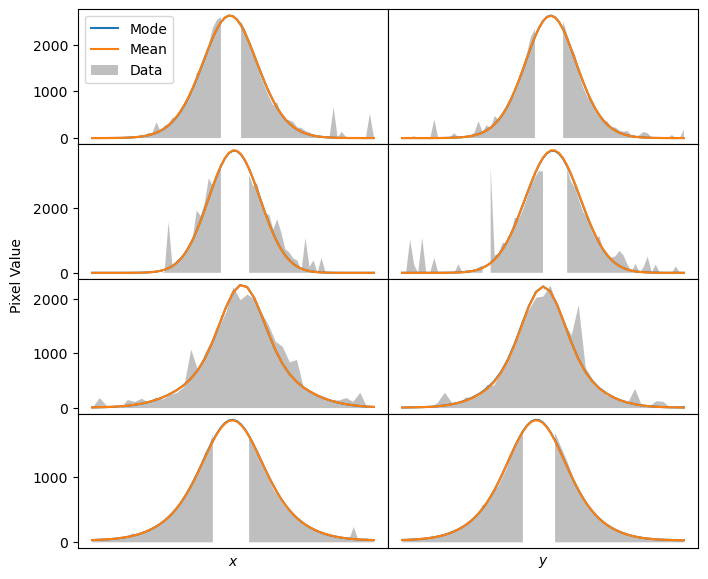

PyObject Text(0.04, 0.5, 'Pixel Value')

In [30]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_crossections(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

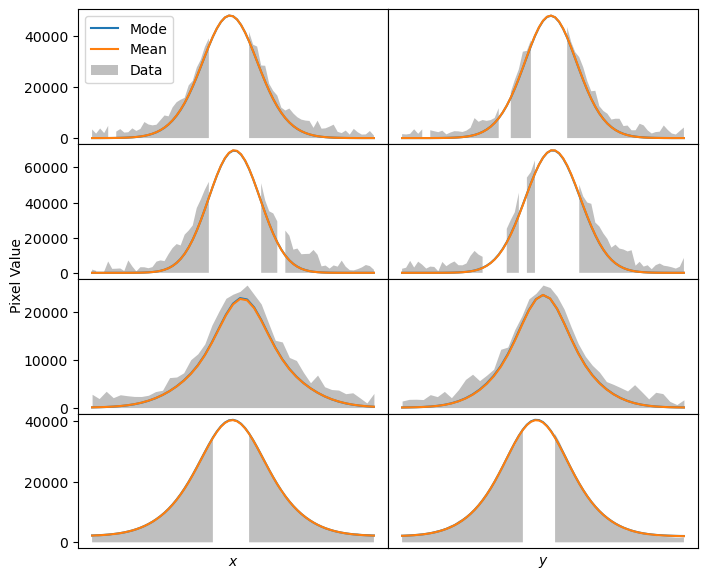

PyObject Text(0.04, 0.5, 'Pixel Value')

In [31]:
colors_array = ["C0", "C1"]
labels_array = ["Mode", "Mean"]
params_array = [mode(samples)[1], mean(samples)[1]]

plot_cam_integral(params_array, event, conv_matrices, colors = colors_array, labels=labels_array)

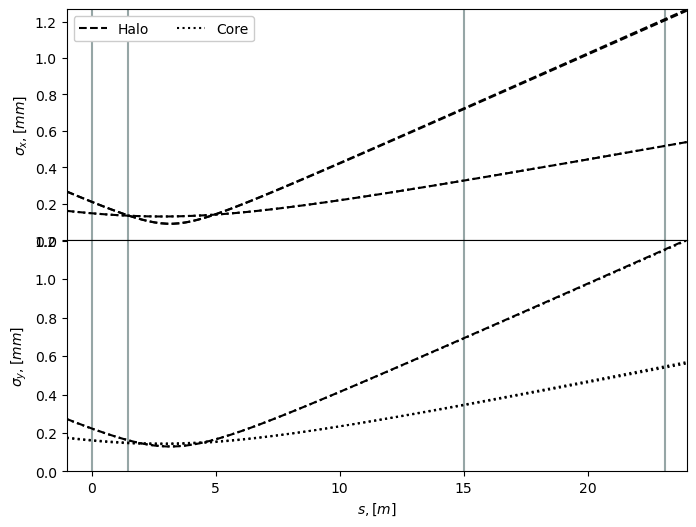

PyObject Text(0.5, 26.28125, '$s, [m]$')

In [32]:
params_array = [mode(samples)[1], mean(samples)[1]]
colors_array = ["gray", "C0", "C1"]
labels_array = ["Truth", "Mode", "Mean"]

plot_envelop_trajectory(params_array,  labels = labels_array, colors=colors_array)

In [33]:
images = load("../data/experiment/dataset_2/m1/images.jld2")
event_ns = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
);

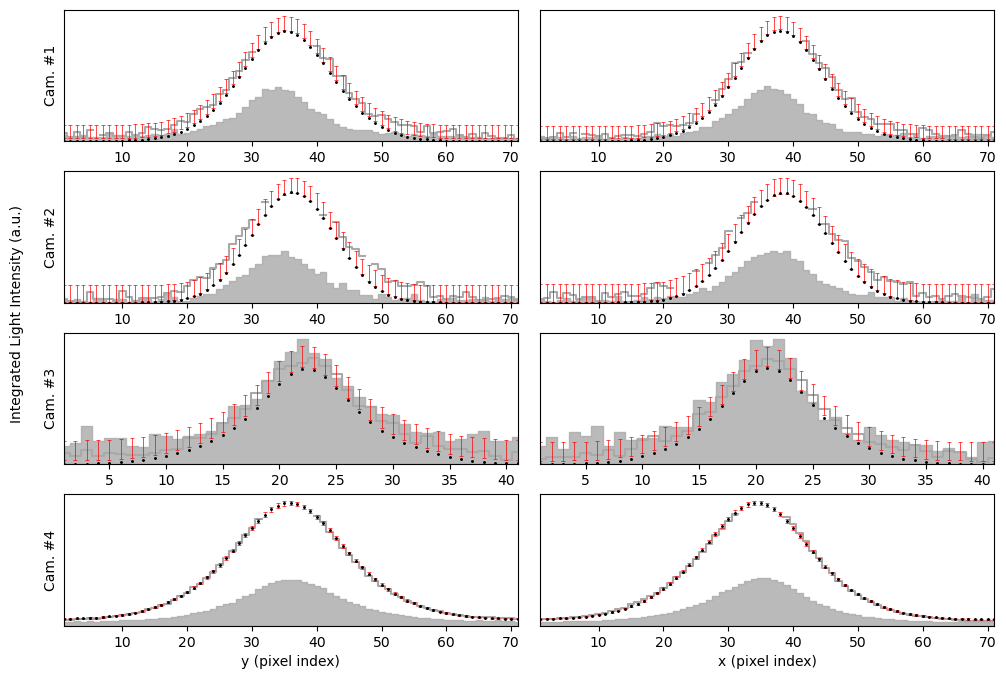

PyObject Text(0.08, 0.5, 'Integrated Light Intensity (a.u.)')

In [34]:
plot_projections(conv_matrices, event_ns, event, params_array[1], isnontr = true)

In [ ]:
# try model 38 with light fluctuations constant on the IS2
# fixe resolution in the IS2 amera